# Problem Description:
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected
using hashtag based supervision but such datasets are noisy in terms of labels and
language. Furthermore, many tweets are replies to other tweets and detecting
sarcasm in these requires the availability of contextual tweets.
In this hands-on project, the goal is to build a model to detect whether a sentence
is sarcastic or not, using Bidirectional LSTMs.

# Data Description:
News Headlines dataset for Sarcasm Detection. The dataset is collected from two
news websites, theonion.com and huffingtonpost.com. This new dataset has the
following advantages over the existing Twitter datasets:
Since news headlines are written by professionals in a formal manner, there are
no spelling mistakes and informal usage. This reduces the sparsity and also
increases the chance of finding pre-trained embedding.
Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we
get high-quality labels with much less noise as compared to Twitter datasets.
Unlike tweets that reply to other tweets, the news headlines obtained are selfcontained. This would help us in teasing apart the real sarcastic elements

# Steps and tasks:

1. Read and explore the data

2. Drop one column

3. Get length of each sentence

4. Define parameters

5. Get indices for words

6. Create features and labels

7. Get vocab size

8. Create a weight matrix using GloVe embeddings

9. Define and compile a Bidirectional LSTM model.

10. Fit the model and check the validation accuracy

# Mount the Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Change current working directory to project folder

In [5]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')
path = '.'

# Loading the Libraries

In [6]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import re

from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas.util.testing as tm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Dataset

In [7]:
df = pd.read_json("/content/drive/My Drive/Colab Notebooks/Sarcasm_Headlines_Dataset.json",lines=True) #Read the file as a json object per line.
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# Data Processing

In [8]:
df.shape #check dimensions

(28619, 3)

In [9]:
df.isna().sum() #check for any nulls

is_sarcastic    0
headline        0
article_link    0
dtype: int64

# Drop one column

In [10]:
df2 = df.iloc[:, :2] #article link is not required for analysis. All saracastic articles - TheOnion, rest are - HuffPost
df2.head(3)

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes


# EDA

Text(0, 0.5, 'Frequency')

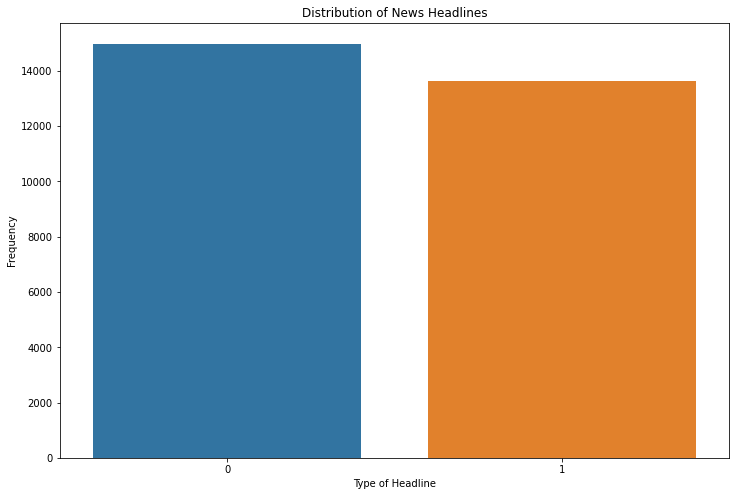

In [11]:
plt.figure(figsize=(12,8)) #Checking for class imbalance

ax = sns.countplot(x="is_sarcastic", data=df2)
plt.title('Distribution of News Headlines')
plt.xlabel('Type of Headline')
plt.ylabel('Frequency')

In [12]:
df2['headline'].describe()

count                                                 28619
unique                                                28503
top       'no way to prevent this,' says only nation whe...
freq                                                     12
Name: headline, dtype: object

In [13]:
pd.set_option('display.max_colwidth', -1) #show all text in col
pd.set_option('display.max_rows', None) #show all rows

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [14]:
df2['headline'].head(50)#observe col to see areas for cleaning

0     thirtysomething scientists unveil doomsday clock of hair loss                                              
1     dem rep. totally nails why congress is falling short on gender, racial equality                            
2     eat your veggies: 9 deliciously different recipes                                                          
3     inclement weather prevents liar from getting to work                                                       
4     mother comes pretty close to using word 'streaming' correctly                                              
5     my white inheritance                                                                                       
6     5 ways to file your taxes with less stress                                                                 
7     richard branson's global-warming donation nearly as much as cost of failed balloon trips                   
8     shadow government getting too large to meet in marriott conference room b         

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
stop = list(stopwords.words('english'))
stop[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [17]:
def lowercase(text): #convert to lower case
      return text.lower()

def remove_punct(text): #remove punctuations using regex
      return re.sub('[^a-z]+',' ',text)

def remove_stopwords(text):  #remove stopwords to aavoid overfitting
    mylist = []
    for i in text.split():
        if i not in stop:
            mylist.append(i)
    return " ".join(mylist)


def cleanmepls(text): #fn to clean col
  text = lowercase(text)
  text = remove_punct(text)
  text = remove_stopwords(text)
  return text

df2['headline_new'] = df2['headline'].apply(cleanmepls)

In [18]:
df2.head(20) #observe changes

,is_sarcastic,headline,headline_new
0,1,thirtysomething scientists unveil doomsday clock of hair loss,thirtysomething scientists unveil doomsday clock hair loss
1,0,"dem rep. totally nails why congress is falling short on gender, racial equality",dem rep totally nails congress falling short gender racial equality
2,0,eat your veggies: 9 deliciously different recipes,eat veggies deliciously different recipes
3,1,inclement weather prevents liar from getting to work,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'streaming' correctly,mother comes pretty close using word streaming correctly
5,0,my white inheritance,white inheritance
6,0,5 ways to file your taxes with less stress,ways file taxes less stress
7,1,richard branson's global-warming donation nearly as much as cost of failed balloon trips,richard branson global warming donation nearly much cost failed balloon trips
8,1,shadow government getting too large to meet in marriott conference room b,shadow government getting large meet marriott conference room b
9,0,lots of parents know this scenario,lots parents know scenario


In [19]:
del df2['headline']

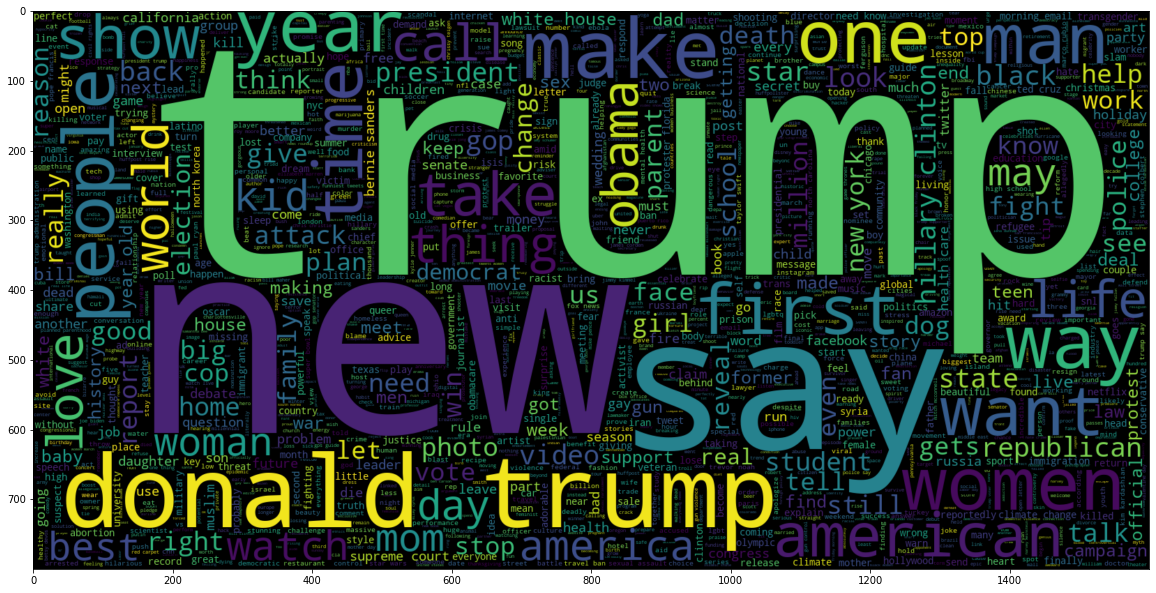

In [20]:
plt.figure(figsize = (20,20)) #fig size
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df2[df2['is_sarcastic'] == 0]['headline_new'])) #News that is Not Sarcastic
plt.imshow(wc , interpolation = 'bilinear')

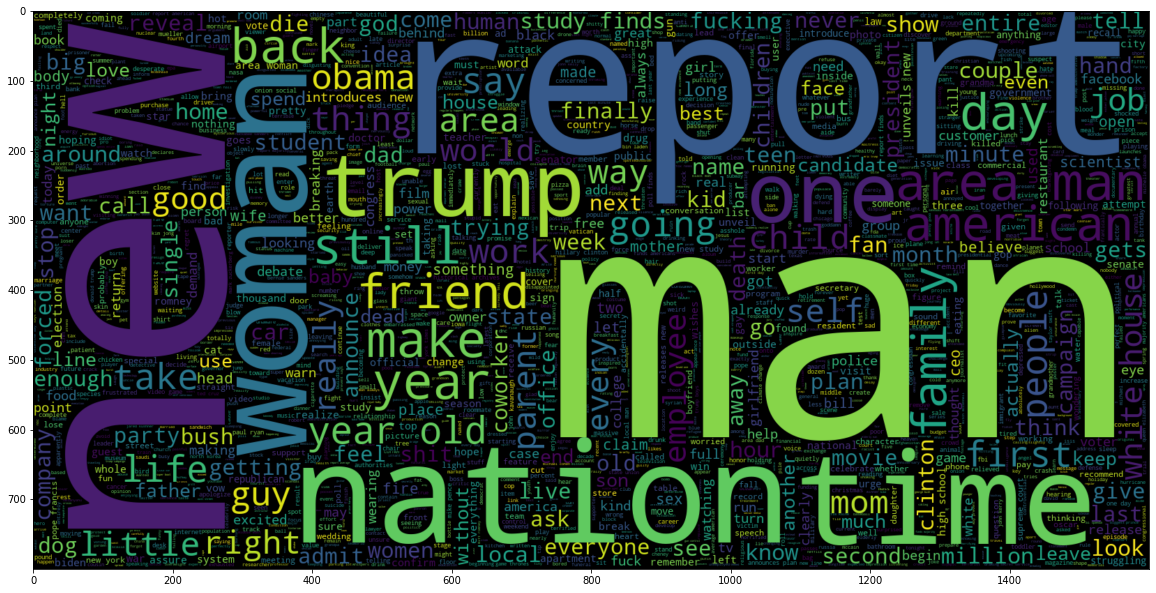

In [21]:
plt.figure(figsize = (20,20)) #fig size
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df2[df2['is_sarcastic'] == 1]['headline_new'])) #News that is Sarcastic
plt.imshow(wc , interpolation = 'bilinear')

# Length of each headline

In [22]:
len_not_sarcastic = df2[df2['is_sarcastic']==0]['headline_new'].str.len() #find length of headline (all characters including spaces)
len_sarcastic = df2[df2['is_sarcastic']==1]['headline_new'].str.len()

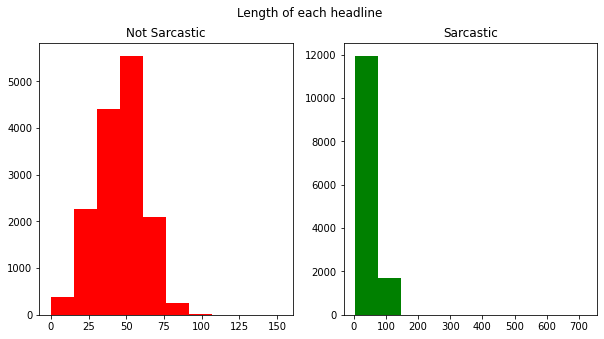

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5)) #subplots to plot side by side

ax1.hist(len_not_sarcastic,color='red')
ax1.set_title('Not Sarcastic')

ax2.hist(len_sarcastic,color='green')
ax2.set_title('Sarcastic')

fig.suptitle('Length of each headline')
plt.show()

# No. of words in each headline

In [24]:
count_not_sarcastic = df2[df2['is_sarcastic']==0]['headline_new'].str.split() #split headline into words
cns=count_not_sarcastic.map(lambda x: len(x)) #find no. of words in a headline

count_sarcastic = df2[df2['is_sarcastic']==1]['headline_new'].str.split()
cs=count_sarcastic.map(lambda x: len(x))

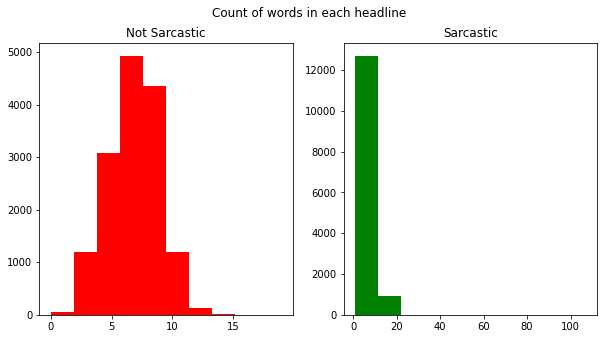

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5)) #subplots to plot side by side

ax1.hist(cns,color='red')
ax1.set_title('Not Sarcastic')

ax2.hist(cs,color='green')
ax2.set_title('Sarcastic')

fig.suptitle('Count of words in each headline')
plt.show() 

### Observation:
sarcastic headlines are much longer and have more words

# Average word length in a headline

In [26]:
avg_not_sarcastic = df2[df2['is_sarcastic']==0]['headline_new'].map(lambda x: [len(i) for i in x.split()]) #length of each word in a news headline
ansc=avg_not_sarcastic.map(lambda x: np.mean(x)) #mean of those lengths

avg_sarcastic = df2[df2['is_sarcastic']==1]['headline_new'].map(lambda x: [len(i) for i in x.split()])
asc=avg_sarcastic.map(lambda x: np.mean(x)) 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


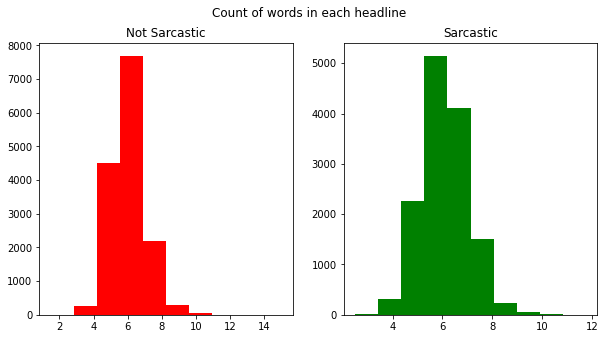

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5)) #subplots to plot side by side

ax1.hist(ansc,color='red')
ax1.set_title('Not Sarcastic')

ax2.hist(asc,color='green')
ax2.set_title('Sarcastic')

fig.suptitle('Count of words in each headline')
plt.show()

# Tokenize

In [28]:
embedding_dim = 200
max_length = 20 #20 words per headline max
trunc_type = 'post'
pad_type = 'post'
training_size = len(df2)
test_portion = 0.3
training_size

28619

In [29]:
tokenizer = Tokenizer() #create tokenizer object 
tokenizer.fit_on_texts(df2['headline_new']) #create word index dict

word_index_dict = tokenizer.word_index #get word index dict
vocab_size = len(word_index_dict) + 1

vocab_size

25766

In [30]:
sequence = tokenizer.texts_to_sequences(df2['headline_new']) #convert words to their vector representations

padding = pad_sequences(sequences=sequence, maxlen=max_length, padding=pad_type, truncating=trunc_type) #pad all sequences, to ensure same length

split = int(test_portion*training_size)
split

8585

# Split train test instances

In [31]:
test_sequences = padding[0:split] 
training_sequences = padding[split:]

labels = df2['is_sarcastic']
test_labels = labels[0:split]
training_labels = labels[split:]

# Load GloVe 200-D

In [32]:
embedding_dict = {} #create embedding dict with words and their 200-D representations
#../input/glove-twitter/glove.twitter.27B.200d.txt
with open('/content/drive/My Drive/Colab Notebooks/glove.6B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float64')
        embedding_dict[word] = coefs

In [33]:
embedding_matrix = np.zeros((vocab_size, embedding_dim)) #create embedding matrix to store weights
embedding_matrix.shape

(25766, 200)

In [34]:
for word, index in word_index_dict.items(): #update embeddings matrix with their GloVe 100-D weights
  embedding_vector = embedding_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [35]:
test_sequences = np.asarray(test_sequences, dtype='int64') #covert to array
training_sequences = np.asarray(training_sequences, dtype='int64')

test_labels = np.asarray(test_labels)
training_labels = np.asarray(training_labels)

# Building RNN Model with LSTM

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False), #we don't want to update/change the learned weights
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.4, return_sequences=False)), #using LSTM gate to overcome vanishing Gradient problem due to long term dependancies
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 200)           5153200   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               135680    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 5,289,009
Trainable params: 135,809
Non-trainable params: 5,153,200
_________________________________________________________________


In [37]:
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics='accuracy')

# Fitting the Model

Find when to stop training and set stopping rounds

In [38]:
num_epochs = 10
history = model.fit(x=training_sequences, y=training_labels, validation_data=(test_sequences, test_labels), epochs = num_epochs, verbose = 1)

Epoch 1/10
627/627 [==============================] - 6s 9ms/step - loss: 0.5343 - accuracy: 0.7296 - val_loss: 0.4667 - val_accuracy: 0.7729
Epoch 2/10
627/627 [==============================] - 5s 8ms/step - loss: 0.4498 - accuracy: 0.7856 - val_loss: 0.4447 - val_accuracy: 0.7891
Epoch 3/10
627/627 [==============================] - 5s 8ms/step - loss: 0.4056 - accuracy: 0.8149 - val_loss: 0.3997 - val_accuracy: 0.8165
Epoch 4/10
627/627 [==============================] - 5s 8ms/step - loss: 0.3700 - accuracy: 0.8351 - val_loss: 0.4037 - val_accuracy: 0.8161
Epoch 5/10
627/627 [==============================] - 5s 8ms/step - loss: 0.3380 - accuracy: 0.8507 - val_loss: 0.3959 - val_accuracy: 0.8209
Epoch 6/10
627/627 [==============================] - 5s 8ms/step - loss: 0.3167 - accuracy: 0.8628 - val_loss: 0.4218 - val_accuracy: 0.8197
Epoch 7/10
627/627 [==============================] - 5s 8ms/step - loss: 0.2933 - accuracy: 0.8711 - val_loss: 0.4018 - val_accuracy: 0.8288
Epoch 

# Visualizing Metrics

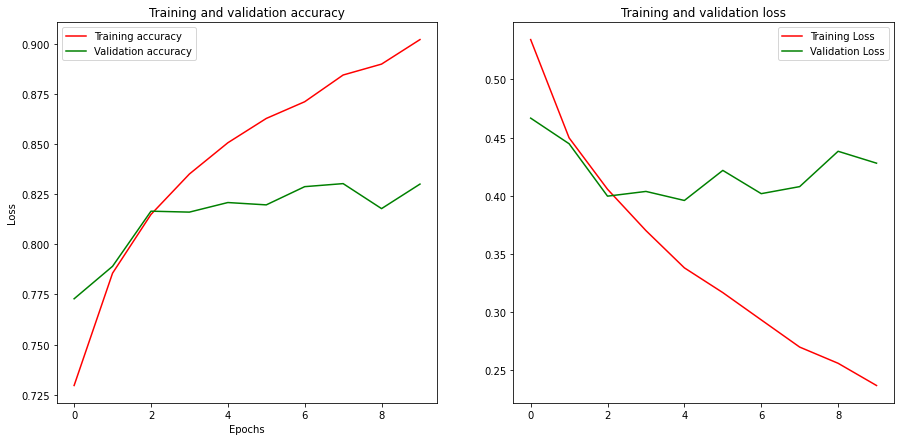

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [i for i in range(10)]

fig, ax = plt.subplots(1,2)

ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'g', label='Validation accuracy')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")


ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'g', label='Validation Loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

fig.set_size_inches(15,7)
plt.show()


## Observation

Stop training after 4 iterations, to avoid overfitting & improve generalization performance

In [40]:
num_epochs = 4
history = model.fit(x=training_sequences, y=training_labels, validation_data=(test_sequences, test_labels), epochs = num_epochs, verbose = 1)

Epoch 1/4
627/627 [==============================] - 5s 8ms/step - loss: 0.2243 - accuracy: 0.9042 - val_loss: 0.4171 - val_accuracy: 0.8295
Epoch 2/4
627/627 [==============================] - 5s 8ms/step - loss: 0.2124 - accuracy: 0.9115 - val_loss: 0.4499 - val_accuracy: 0.8282
Epoch 3/4
627/627 [==============================] - 5s 8ms/step - loss: 0.1983 - accuracy: 0.9205 - val_loss: 0.4310 - val_accuracy: 0.8342
Epoch 4/4
627/627 [==============================] - 5s 8ms/step - loss: 0.1842 - accuracy: 0.9238 - val_loss: 0.4808 - val_accuracy: 0.8189


# Evaluating accuracy and loss on test data

In [41]:
print("Training Loss and Accuracy: ")
loss, accuracy = model.evaluate(training_sequences, training_labels, verbose = 1)
print("Validation Loss and Accuracy: ")
loss, accuracy = model.evaluate(test_sequences, test_labels, verbose = 1)

Training Loss and Accuracy: 
627/627 [==============================] - 2s 3ms/step - loss: 0.0851 - accuracy: 0.9721
Validation Loss and Accuracy: 
269/269 [==============================] - 1s 3ms/step - loss: 0.4808 - accuracy: 0.8189


# Conclusion

We loaded the JSON data file

We analyzed the words depicting Sarcasm

We loaded the Glove library

We created an RNN LSTM model for Sarcasm Detection with 92.38% accuracy